In [1]:
text_labels = [
    "pink primrose", "hard-leaved pocket orchid", "canterbury bells",
    "sweet pea", "english marigold", "tiger lily", "moon orchid",
    "bird of paradise", "monkshood", "globe thistle", "snapdragon",
    "colt's foot", "king protea", "spear thistle", "yellow iris",
    "globe-flower", "purple coneflower", "peruvian lily", "balloon flower",
    "giant white arum lily", "fire lily", "pincushion flower", "fritillary",
    "red ginger", "grape hyacinth", "corn poppy", "prince of wales feathers",
    "stemless gentian", "artichoke", "sweet william", "carnation",
    "garden phlox", "love in the mist", "mexican aster", "alpine sea holly",
    "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip",
    "lenten rose", "barbeton daisy", "daffodil", "sword lily", "poinsettia",
    "bolero deep blue", "wallflower", "marigold", "buttercup", "oxeye daisy",
    "common dandelion", "petunia", "wild pansy", "primula", "sunflower",
    "pelargonium", "bishop of llandaff", "gaura", "geranium", "orange dahlia",
    "pink-yellow dahlia?", "cautleya spicata", "japanese anemone",
    "black-eyed susan", "silverbush", "californian poppy", "osteospermum",
    "spring crocus", "bearded iris", "windflower", "tree poppy", "gazania",
    "azalea", "water lily", "rose", "thorn apple", "morning glory",
    "passion flower", "lotus", "toad lily", "anthurium", "frangipani",
    "clematis", "hibiscus", "columbine", "desert-rose", "tree mallow",
    "magnolia", "cyclamen", "watercress", "canna lily", "hippeastrum",
    "bee balm", "ball moss", "foxglove", "bougainvillea", "camellia", "mallow",
    "mexican petunia", "bromelia", "blanket flower", "trumpet creeper",
    "blackberry lily"
]

In [2]:
import tensorflow as tf
import numpy as np
import random
import scipy.io
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV3Large, MobileNetV3Small, MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
## UNCOMMENT ONLY IF UNZIPPING DATASET ###

import zipfile

with zipfile.ZipFile("jpg.zip", "r") as zip_ref:
    zip_ref.extractall("images")


folder_path = "images/jpg"

# Count all files (excluding subdirectories)
file_count = sum(1 for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file)))

print(f"Number of files: {file_count}")


Number of files: 8189


### Augmentation

In [4]:
import os
import random
import numpy as np
import tensorflow as tf
import scipy.io

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# -----------------------------------------------------------------------------
# OxfordFlowersDataset
# -----------------------------------------------------------------------------
class OxfordFlowersDataset:
    def __init__(self, image_folder, label_file):
        self.image_folder = image_folder
        self.label_file = label_file
        self.image_files = sorted([
            f for f in os.listdir(image_folder)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        self.labels = self._load_labels()

    def _load_labels(self):
        label_data = scipy.io.loadmat(self.label_file)
        image_labels = label_data['labels'].flatten() - 1
        return to_categorical(image_labels, num_classes=102)

# -----------------------------------------------------------------------------
# Augmentation function
# -----------------------------------------------------------------------------
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)
    image = tf.image.random_hue(image, max_delta=0.05)
    image = tf.image.rot90(
        image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )
    return image

# -----------------------------------------------------------------------------
# Replicate each image into (1 + num_augs) copies
#    => but store them in *parallel arrays* (paths, flags, labels)
# -----------------------------------------------------------------------------
def replicate_for_training(image_paths, labels, num_augmentations=3):
    """
    For each original (path, label), produce:
      - One entry with flag=0  (the "original")
      - num_augmentations entries with flag=1 (the "augmented" copies)
    Returns 3 lists of length N*(1+num_augmentations):
      final_paths: list of str
      final_flags: list of int (0/1)
      final_labels: list of 1D one-hot (length=102)
    """
    final_paths = []
    final_flags = []
    final_labels = []

    for path, lab in zip(image_paths, labels):
        # 1) Original
        final_paths.append(path)
        final_flags.append(0)
        final_labels.append(lab)

        # 2) Augmented copies
        for _ in range(num_augmentations):
            final_paths.append(path)
            final_flags.append(1)
            final_labels.append(lab)

    return final_paths, final_flags, final_labels

# -----------------------------------------------------------------------------
# The map function that actually loads + conditionally augments
# -----------------------------------------------------------------------------
def load_image_conditional(path, flag, label):
    """
    path:  tf.string
    flag:  tf.int32 (0 => original, 1 => augmented)
    label: one-hot vector (shape=[102])
    """
    # Load & preprocess
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32)
    # MobileNetV2 => [-1,1]
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)

    # If flag==1 => apply data augmentation
    image = tf.cond(
        tf.equal(flag, 1),
        lambda: augment_image(image),
        lambda: image
    )
    return image, label

# -----------------------------------------------------------------------------
# Build the train or val dataset
# -----------------------------------------------------------------------------
def build_dataset(image_paths, labels, batch_size=32, shuffle=True, training=True, num_augmentations=3):
    if training:
        # Expand each image into (1 + num_augmentations) copies
        final_paths, final_flags, final_labels = replicate_for_training(
            image_paths, labels, num_augmentations
        )
    else:
        # Validation => no augmentation => all flags = 0
        final_paths = list(image_paths)
        final_flags = [0]*len(image_paths)
        final_labels = list(labels)

    # Create a dataset of (path, flag, label) => string, int, float
    dataset = tf.data.Dataset.from_tensor_slices((final_paths, final_flags, final_labels))

    # Map to (image, label)
    dataset = dataset.map(load_image_conditional, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(final_paths))

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset



# 1) Load Oxford Flowers
dataset = OxfordFlowersDataset("images/jpg", "imagelabels.mat")
image_paths = [os.path.join("images/jpg", f) for f in dataset.image_files]
labels = dataset.labels

# 2) Shuffle in Python
combined = list(zip(image_paths, labels))
random.shuffle(combined)
image_paths, labels = zip(*combined)

# 3) Train/val split
label_indices = np.argmax(labels, axis=1)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths,
    labels,
    test_size=0.2,
    stratify=label_indices,
    random_state=42
)

# 4) Build the train_dataset (with augmented copies) and val_dataset
train_dataset = build_dataset(
    train_paths,
    train_labels,
    batch_size=32,
    shuffle=True,
    training=True,        # => replicate + augment
    num_augmentations=3   # => 1 original + 3 augmented
)

val_dataset = build_dataset(
    val_paths,
    val_labels,
    batch_size=32,
    shuffle=False,
    training=False        # => original only
)



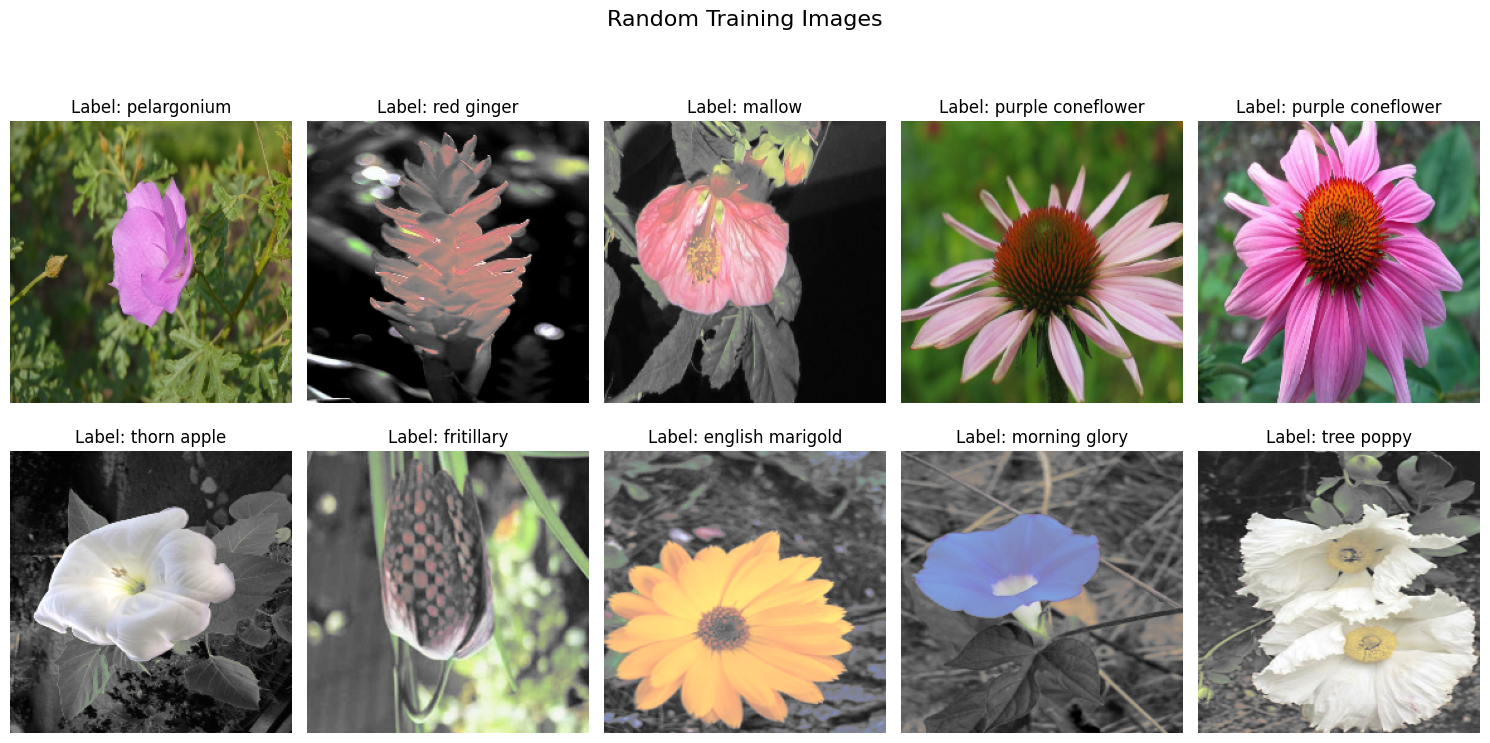

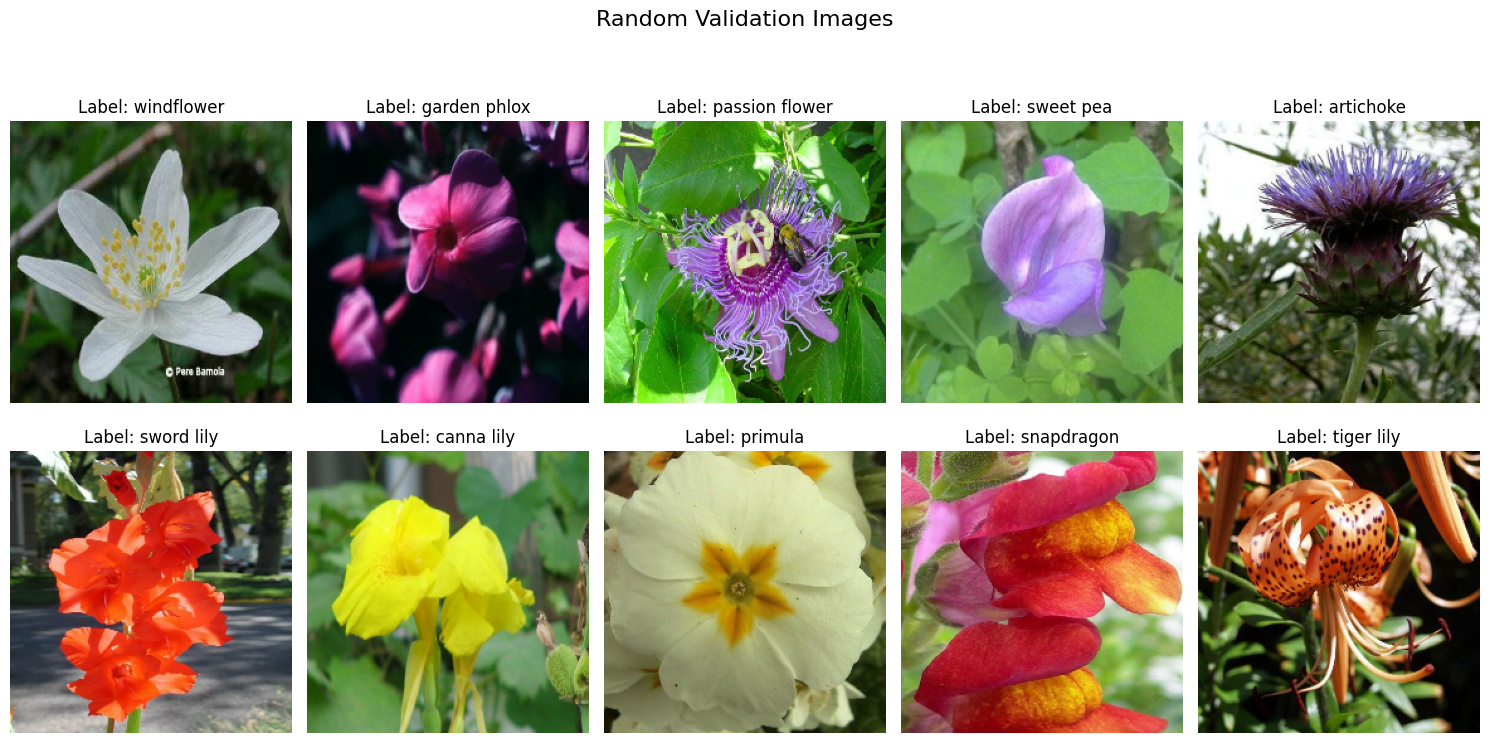

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def display_images(dataset, num_images=10, title=""):
    """Displays a grid of images from a tf.data.Dataset.

    Args:
        dataset: A tf.data.Dataset containing (image, label) pairs.
        num_images: The number of images to display.
        title: The title of the plot.
    """
    # Take a subset of the dataset.  We use 'take' because datasets can be infinite.
    subset = dataset.take(num_images)

    plt.figure(figsize=(15, 8))  # Adjust figure size as needed
    plt.suptitle(title, fontsize=16)

    for i, (image, label) in enumerate(subset):
        plt.subplot(2, 5, i + 1)  # Create a 2x5 grid of subplots

        # Since the images are preprocessed to [-1, 1], reverse this to [0, 1] for proper display with imshow.
        display_image = (image.numpy() + 1) / 2.0

        # Ensure the image is within the valid range [0, 1]
        display_image = np.clip(display_image, 0, 1)
        label_num = np.argmax(label.numpy())
        plt.imshow(display_image)
        plt.title(f"Label: {text_labels[label_num]}")  # Show the text class label
        plt.axis('off')  # Hide axes

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to prevent title overlap
    plt.show()

# --- Display Training Images ---
display_images(train_dataset.unbatch(), num_images=10, title="Random Training Images")

# --- Display Validation Images ---
display_images(val_dataset.unbatch(), num_images=10, title="Random Validation Images")

## Feature Extraction

In [7]:
# Load MobileNetV3 Model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Build Model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(102, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))  # 102 flower classes
])

# Compile Model (Feature Extraction)
model.compile(
      optimizer=optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')]
)

# Train for initial feature extraction
initial_epochs = 15
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=initial_epochs
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
819/819 ━━━━━━━━━━━━━━━━━━━━ 55s 38ms/step - accuracy: 0.5594 - loss: 2.2560 - val_accuracy: 0.8626 - val_loss: 0.9110
Epoch 2/15
819/819 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.8846 - loss: 0.7960 - val_accuracy: 0.8803 - val_loss: 0.7794
Epoch 3/15
819/819 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.9091 - loss: 0.6755 - val_accuracy: 0.8907 - val_loss: 0.7294
Epoch 4/15
819/819 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.9179 - loss: 0.6384 - val_accuracy: 0.8834 - val_loss: 0.7350
Epoch 5/15
819/819 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.9194 - loss: 0.6206 - val_accuracy: 0.8895 - val_loss: 0.7228
Epoch 6/15
819/819 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.9248 - loss: 0.6098 - val_accuracy: 0.9011 - val_loss: 0.7187
Epoch 7/15
819/819 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.9232 - loss: 0.6151 - val_accuracy: 0.8907 - val_loss: 0.7208
Epoch 8/15
819/819 ━━━━━━━━━━━━━━━━━━━━ 2

## Fine-tunning

In [8]:

# Unfreeze the last ~30 layers of MobileNetV2 for deeper fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]

fine_tune_epochs = 50
history_fine = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=fine_tune_epochs,
    callbacks=callbacks
)

Epoch 1/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 58s 38ms/step - accuracy: 0.8952 - loss: 1.6055 - val_accuracy: 0.9048 - val_loss: 1.6043 - learning_rate: 1.0000e-04
Epoch 2/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.9815 - loss: 1.2809 - val_accuracy: 0.9267 - val_loss: 1.4373 - learning_rate: 1.0000e-04
Epoch 3/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.9919 - loss: 1.1876 - val_accuracy: 0.9463 - val_loss: 1.3078 - learning_rate: 1.0000e-04
Epoch 4/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.9958 - loss: 1.1233 - val_accuracy: 0.9591 - val_loss: 1.2156 - learning_rate: 1.0000e-04
Epoch 5/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.9972 - loss: 1.0723 - val_accuracy: 0.9640 - val_loss: 1.1638 - learning_rate: 1.0000e-04
Epoch 6/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.9981 - loss: 1.0314 - val_accuracy: 0.9683 - val_loss: 1.1290 - learning_rate: 1.0000e-04
Epoch 7/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 31s 23ms/ste

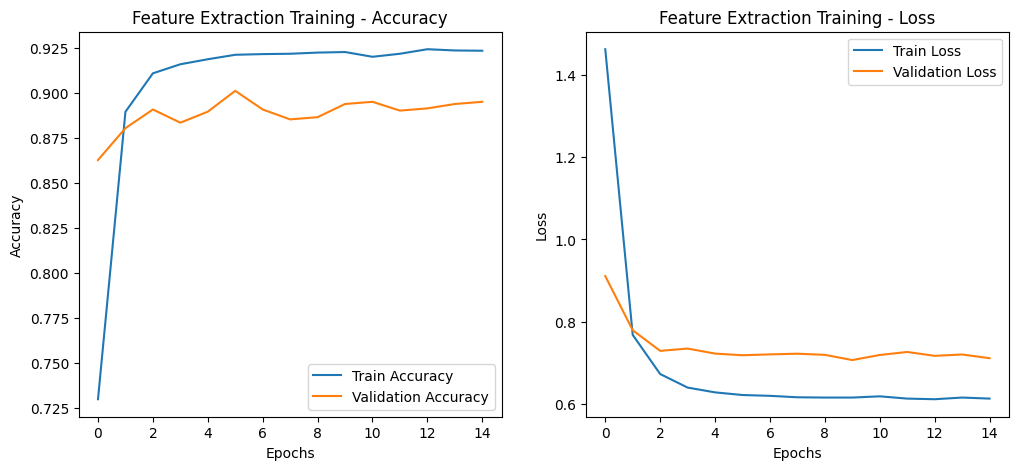

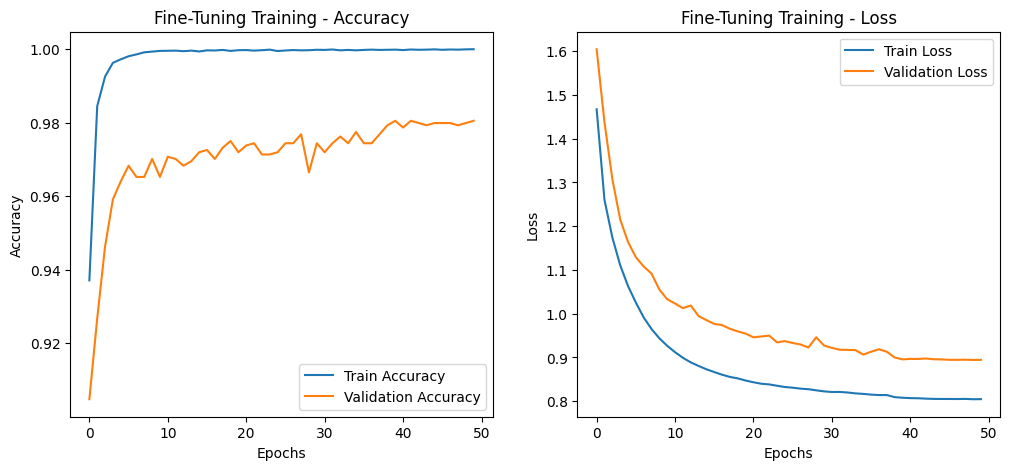

In [9]:
# Plot Training Metrics
def plot_metrics(history, title="Model Performance"):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.show()

# Display Metrics
plot_metrics(history, title="Feature Extraction Training")
plot_metrics(history_fine, title="Fine-Tuning Training")


In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 119.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 31.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successf

In [ ]:
# prompt: delete all files in given list of folders as well as folders themselves

import shutil
import os

def delete_folders(folders_to_delete):
  """Deletes a list of folders and their contents.

  Args:
    folders_to_delete: A list of folder paths to delete.
  """
  for folder in folders_to_delete:
    if os.path.exists(folder):
      try:
          shutil.rmtree(folder)
          print(f"Successfully deleted folder: {folder}")
      except OSError as e:
          print(f"Error deleting folder {folder}: {e}")
    else:
      print(f"Folder not found: {folder}")


# Example usage (replace with your folder paths)
folders_to_delete = ["model"]
delete_folders(folders_to_delete)


Folder not found: flower_classifier_tfjs
Folder not found: flower_classifier_tfjs_1
Folder not found: flower_classifier_tfjs_2
Folder not found: flower_classifier_tfjs_legacy
Folder not found: flower_classifier_tfjs_legacy_1
Folder not found: converted_model
Successfully deleted folder: model
Folder not found: sample_data


In [ ]:
import tensorflowjs as tfjs

tf.saved_model.save(model, "model/tf/mobileV2/")
# tfjs.converters.save_keras_model(model, "flower_classifier_tfjs")

# model.save("flower_classifier_keras_model.h5")
# tfjs.converters.save_keras_model(model, "model/h5/flower_classifier_tfjs_h5")

In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model --saved_model_tags=serve --weight_shard_size_bytes=30000000 model/tf/mobileV2/ model/tf2js/mobileV2

2025-03-02 23:09:34.664666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740956974.687058   74528 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740956974.693768   74528 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-03-02 23:09:38.991849: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1740956978.991992   74528 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

## Test Model

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import scipy.io
import os  # Import os

# Load the SavedModel
loaded_model = tf.saved_model.load("model/tf/mobileV2/")
infer = loaded_model.signatures["serving_default"]

label_data = scipy.io.loadmat("imagelabels.mat")
image_labels = label_data['labels'].flatten() - 1  # 0-based indexing

# Create class_names (assuming sorted filenames match label order)
class_names = [None] * 102
for i in range(len(image_labels)):
    label = image_labels[i]
    if class_names[label] is None:
      class_names[label] = label


# --- Image loading and preprocessing ---
img_path = 'waterlily.jpeg'  # YOUR IMAGE PATH
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make a Prediction
input_name = list(infer.structured_input_signature[1].keys())[0]
predictions = infer(tf.constant(img_array, dtype=tf.float32))
predictions = predictions[list(predictions.keys())[0]]

# --- Get Top-k Predictions and Decode ---
top_k = 10
top_k_indices = np.argsort(predictions[0].numpy())[::-1][:top_k]
top_k_probabilities = tf.gather(predictions[0], top_k_indices).numpy() * 100
top_k_class_names = [text_labels[i] for i in top_k_indices]


# Print the results
print(f"Top {top_k} Predictions:")
for i in range(top_k):
    print(f"  {i+1}. Class: {top_k_class_names[i]}, Probability: {top_k_probabilities[i]:.2f}%")

Top 10 Predictions:
  1. Class: water lily, Probability: 79.09%
  2. Class: great masterwort, Probability: 12.22%
  3. Class: orange dahlia, Probability: 4.13%
  4. Class: tree poppy, Probability: 1.24%
  5. Class: clematis, Probability: 0.46%
  6. Class: gaura, Probability: 0.30%
  7. Class: colt's foot, Probability: 0.22%
  8. Class: lenten rose, Probability: 0.20%
  9. Class: pincushion flower, Probability: 0.18%
  10. Class: bishop of llandaff, Probability: 0.17%
